In [1]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver import Keys, ActionChains
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import sqlalchemy
import csv
import os
from datetime import date, timedelta, datetime

In [2]:
details_names = [
    'bus_id',
    'bus_name',
    'bus_type',
    'duration',
    'date_dep',
    'date_arrival',
    'time_dep',
    'time_arrival',
    'star_rate',
    'price',
    'seat_available',
    'route_name',
    'loc_dep',
    'loc_arrival',
    'operator',
]

In [3]:
def scroll_to_load(driver, wait):
    scroll_wait_sec = wait
    while True:
        time1 = time.time()
        init_height = driver.execute_script("return document.body.scrollHeight")

        while True:
            time.sleep(.001)
            new_height = driver.execute_script("return document.body.scrollHeight")
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time2 = time.time()
            if (time2 - time1) > scroll_wait_sec:
                break
            if new_height != init_height:
                break
            
        if (time2 - time1) > scroll_wait_sec:
            break

In [ ]:
def get_bus_details_df(buses_section, route_name, operator, search_date):
    print(f'started making df of {operator}')
    bus_id =         buses_section.find_elements(By.XPATH,".//li[@class='row-sec clearfix']")
    bus_name =       buses_section.find_elements(By.XPATH,".//div[@class='travels lh-24 f-bold d-color']")
    bus_type =       buses_section.find_elements(By.XPATH,".//div[@class='bus-type f-12 m-top-16 l-color evBus']") 
    time_dep =       buses_section.find_elements(By.XPATH,".//div[@class='dp-time f-19 d-color f-bold']")
    dur =            buses_section.find_elements(By.XPATH,".//div[@class='dur l-color lh-24']")
    time_arrival =   buses_section.find_elements(By.XPATH,".//div[@class='bp-time f-19 d-color disp-Inline']")
    star_rate =      buses_section.find_elements(By.XPATH,".//div[@class='column-six p-right-10 w-10 fl']")
    price =          buses_section.find_elements(By.XPATH,".//*[@class='f-bold f-19' or @class='f-19 f-bold']")
    seat_available = buses_section.find_elements(By.XPATH,".//div[contains(@class,'seat-left m-top-')]")
    date_dep =       buses_section.find_elements(By.XPATH,".//div[@class='column-three p-right-10 w-10 fl']")
    date_arrival =   buses_section.find_elements(By.XPATH,".//div[@class='column-five p-right-10 w-10 fl']")

    details = {
        'bus_id': bus_id,
        'bus_name': bus_name,
        'bus_type': bus_type,
        'dur': dur,
        'date_dep': date_dep,
        'date_arrival': date_arrival,
        'time_dep': time_dep,
        'time_arrival': time_arrival,
        'star_rate': star_rate,
        'price': price,
        'seat_available': seat_available,
    }

    # get the bus id by using get_attribute and text methods
    for detail_name in details:
        for detail_i in range(len(details[detail_name])):
            if detail_name == 'bus_id':
                details[detail_name][detail_i] = details[detail_name][detail_i].get_attribute('id')
            else:
                try:
                    # print(detail_name, details[detail_name][detail_i].text)
                    details[detail_name][detail_i] = details[detail_name][detail_i].text
                except:
                    details[detail_name][detail_i] = ''
                    print(detail_name, "text error", details['date_arrival'][detail_i].text)

            if detail_name == 'star_rate':
                val = details[detail_name][detail_i].split("\n")[0]     #  Access and split the star rating text
                if '.' in val:
                    val = float(val)    #  Convert to float if it contains a decimal
                else:
                    val = ''            #  Set to an empty string if it's not a valid number.
                details[detail_name][detail_i] = val     # Update the value in the dictionary.

            
            if detail_name in ['date_arrival', 'date_dep']:
                if detail_name == 'date_arrival':
                    sp = details[detail_name][detail_i].split("\n")
                    if len(sp) <= 2:
                        date_str = search_date
                    else:
                        date_str = details[detail_name][detail_i].split("\n")[1] + ' 2024'
                
                elif detail_name == 'date_dep':
                    date_str = search_date

                # try:
                details[detail_name][detail_i] = datetime.strptime(date_str, '%d-%b %Y').strftime('%Y-%m-%d')   # convert date (10-Aug-2024) into std date (2024-08-10) format
                # except Exception as e:
                    # print('error from', details['bus_id'][detail_i])
                    # print(f"Error parsing date: {e}")
                    # details[detail_name][detail_i] = ''


            if detail_name in ['time_arrival', 'time_dep']:
                if detail_name == 'time_arrival': 
                    date_str = str(details['date_arrival'][detail_i])
                elif detail_name == 'time_dep': 
                    date_str = str(details['date_dep'][detail_i])

                string_time = date_str + " " + details[detail_name][detail_i]

                # try:
                time_object = datetime.strptime(string_time, '%Y-%m-%d %H:%M')       
                details[detail_name][detail_i] = str(time_object)
                # except Exception as e:

                #     print('error from', details['bus_id'][detail_i])
                #     print('time_text', details[detail_name][detail_i])
                #     print(f"Error parsing date-time: {e}")
                #     details[detail_name][detail_i] = ''
            

            if detail_name == 'seat_available':
                # try:
                val = int(details[detail_name][detail_i].split()[0])
                details[detail_name][detail_i] = val
                # except Exception as e:
                #     print('seat error from', details['bus_id'][detail_i], details['date_arrival'][detail_i])
                #     print('seat text', details[detail_name][detail_i])
                #     print(f"Error parsing date-time: {e}")
                #     details[detail_name][detail_i] = ''


            if detail_name == 'bus_type':
                details[detail_name][detail_i] = details[detail_name][detail_i].replace(
                    'A/C','AC').replace(
                    'A.C','AC').replace(
                    'Non AC','NON AC').replace(
                    'NON-AC','NON AC')


    # print(details)
    details_df = pd.DataFrame(details)

    details_df['route_name'] = route_name
    details_df['loc_dep'] = route_name.split()[0]
    details_df['loc_arrival'] = route_name.split()[2]

    details_df['operator'] = operator

    return details_df

In [4]:
from selenium.common.exceptions import StaleElementReferenceException, TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from datetime import datetime

def get_bus_details_df(buses_sections, route_name, bus_operator, search_date):
    bus_id = buses_sections.find_elements(By.XPATH,"//li[@class='row-sec clearfix']")
    # bus_name = buses_sections.find_elements(By.XPATH,"//div[@class='travels lh-24 f-bold d-color']")
    # bus_type = buses_sections.find_elements(By.XPATH,"//div[@class='bus-type f-12 m-top-16 l-color evBus']") 
    # time_dep = buses_sections.find_elements(By.XPATH,"//div[@class='dp-time f-19 d-color f-bold']")
    # duration = buses_sections.find_elements(By.XPATH,"//div[@class='dur l-color lh-24']")
    # time_arrival = buses_sections.find_elements(By.XPATH,"//div[@class='bp-time f-19 d-color disp-Inline']")
    # star_rate = buses_sections.find_elements(By.XPATH,"//div[@class='column-six p-right-10 w-10 fl']")
    # price = buses_sections.find_elements(By.XPATH,"//*[@class='f-bold f-19' or @class='f-19 f-bold']")
    # seat_available = buses_sections.find_elements(By.XPATH,"//div[contains(@class,'seat-left m-top-')]")
    # date_dep = buses_sections.find_elements(By.XPATH,"//div[@class='column-three p-right-10 w-10 fl']")
    # date_arrival = buses_sections.find_elements(By.XPATH,"//div[@class='column-five p-right-10 w-10 fl']")

    details = {
        'bus_id': bus_id,
        # 'bus_name': bus_name,
        # 'bus_type': bus_type,
        # 'duration': duration,
        # 'date_dep': date_dep,
        # 'date_arrival': date_arrival,
        # 'time_dep': time_dep,
        # 'time_arrival': time_arrival,
        # 'star_rate': star_rate,
        # 'price': price,
        # 'seat_available': seat_available,
    }

    for detail_name in details:
        for detail_i in range(len(details[detail_name])):
            # try:    
                if detail_name == 'bus_id':
                    details[detail_name][detail_i] = details[detail_name][detail_i].get_attribute('id')
                else:
                    # try:
                    details[detail_name][detail_i] = details[detail_name][detail_i].text
                    # except:
                    #     details[detail_name][detail_i] = ''
                    #     print("bus id error")
                        

            #     if detail_name == 'star_rate':
            #         val = details[detail_name][detail_i].split("\n")[0]
            #         if '.' in val:
            #             val = float(val)
            #         else:
            #             val = ''
            #         details[detail_name][detail_i] = val

                
            #     if detail_name in ['date_arrival', 'date_dep']:
            #         if detail_name == 'date_arrival':
            #             sp = details[detail_name][detail_i].split("\n")
            #             if len(sp) <= 2:
            #                 date_str = search_date
            #             else:
            #                 date_str = details[detail_name][detail_i].split("\n")[1] + ' 2024'
            #         elif detail_name == 'date_dep':
            #             date_str = search_date
            #         try:
            #             details[detail_name][detail_i] = datetime.strptime(date_str, '%d-%b %Y').strftime('%Y-%m-%d')
            #         except:
            #             details[detail_name][detail_i] = ''
            #             print("date format error")


            #     if detail_name in ['time_arrival', 'time_dep']:
            #         if detail_name == 'time_arrival': 
            #             date_str = str(details['date_arrival'][detail_i])
            #         elif detail_name == 'time_dep': 
            #             date_str = str(details['date_dep'][detail_i])
            #         try:
            #             string_time = date_str + " " + details[detail_name][detail_i]
            #             time_object = datetime.strptime(string_time, '%Y-%m-%d %H:%M')
            #             details[detail_name][detail_i] = str(time_object)
            #         except:
            #             details[detail_name][detail_i] = ''
            #             print("time format error")
            
            #     if detail_name == 'seat_available':
            #         val = int(details[detail_name][detail_i].split(" ")[0])
            #         details[detail_name][detail_i] = val


            #     if detail_name == 'bus_type':
            #         details[detail_name][detail_i] = details[detail_name][detail_i].replace(
            #             'A/C','AC').replace(
            #             'A.C','AC').replace(
            #             'Non AC','NON AC').replace(
            #             'NON-AC','NON AC')
            
            # except StaleElementReferenceException:
            #     print(f"StaleElementReferenceException encountered for {detail_name} at index {detail_i}")
            #     continue

            # except ValueError as e:
            #     print(f"ValueError encountered for {detail_name} at index {detail_i}: {e}")
            #     details[detail_name][detail_i] = ''

                
    # print(details)
    details_df = pd.DataFrame(details)

    details_df['route_name'] = route_name
    details_df['loc_dep'] = route_name.split()[0]
    details_df['loc_arrival'] = route_name.split()[2]
    details_df['operator'] = bus_operator
    
    return details_df

In [5]:
df = pd.read_csv('routes.csv')
routes_details = df.values.tolist()
# print(routes_details)

In [6]:
filename = "scrape_buses.csv"

In [7]:
date = '13-Aug-2024'

In [ ]:
# display current datatime while start retrieving the data
print(datetime.now(), 'scraping started')

# open chrome driver
driver = webdriver.Chrome()

# maximize window
driver.maximize_window()

search_date = None

# Iterate bus route details  
for route_i in range(len(routes_details)):
        route_details = routes_details[route_i]
        link = route_details[2]                     # get route link at index 2 from routes csv
        route_name = route_details[1]
        print(datetime.now(), 'scraping -', len(routes_details)-route_i, route_name)
        
        # create an empty list
        dfs = []
        
        driver.get(link)                            # get the route link
        full_url = driver.current_url               # convert route link into current url include with date
        driver.get(full_url + f'&onward={date}')    # based on bus routes city_id, get the current url

        if not search_date:
            search_date = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID,"searchDat"))).get_attribute('value').replace(' ', '-') + ' 2024'
        
        scroll_to_load(driver, 5)

        # private bus details
        private_bus_section = None
        try:
            private_bus_section = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME,"bus-items")))
        except:
            print('private buses not found')
        
        if private_bus_section:
            private_df = get_bus_details_df(private_bus_section, route_name, 'private', search_date)
            dfs.append(private_df)
    

        # govt bus details
        govt_buttons = None
        try:
            govt_buttons = WebDriverWait(driver, 5).until(EC.presence_of_all_elements_located(
                (By.XPATH,"//div[contains(@class, 'button') and contains(text(), 'View Buses')]")
            ))
        except:
            print("govt buses not found")

        if govt_buttons:
            for govt_button in govt_buttons[::-1]:                  # by using reverse scrolling technique, to click the view buses icon
                driver.execute_script("window.scrollTo(0, 0);")
                # print(govt_button.text)
                # print(govt_button.get_attribute('class'))
                govt_button.click()
                scroll_to_load(driver, 1)
                govt_bus_sections = WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CLASS_NAME,"group-data")))
            
                for govt_bus_section in govt_bus_sections:
                    govt_df = get_bus_details_df(govt_bus_section, route_name, 'govt', search_date)
                    dfs.append(govt_df)

        # display the scraped bus route details
        print(datetime.now(), 'scraped -', route_name)

        # convert the bus details into dataframe using pandas
        buses_df = pd.DataFrame()
        if len(dfs) > 1:                                            # if more than one df occurs       
            buses_df = pd.concat(dfs).reset_index(drop=True)        # concatenate the dataframe into one df
        elif len(dfs) == 1:
            buses_df = dfs[0]

        if not buses_df.empty:
            file_exists = os.path.isfile(filename)                                      
            buses_df.to_csv(filename, mode='a', header=not file_exists, index=False)    # Opens the file in append mode, if the file does exist, it skips the header to avoid duplicating it. If the file doesn't exist, it creates new header column.
            print(datetime.now(), 'added csv - ', route_name)

# display the status of the scraped data
print(datetime.now(), 'all scraping completed')

In [ ]:
# from selenium.common.exceptions import NoSuchElementException

print(datetime.now(), 'scraping started')

driver = webdriver.Chrome()

search_date = None

  
for route_i in range(len(routes_details)):
        route_details = routes_details[route_i]
        link = route_details[2]
        route_name = route_details[1]
        print(datetime.now(), 'scraping -', len(routes_details)-route_i, route_name)

        dfs= []
        
        driver.get(link)
        full_url = driver.current_url
        driver.get(full_url + '&onward=12-Aug-2024')

        if not search_date:
            search_date = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID,"searchDat"))).get_attribute('value').replace(' ', '-') + ' 2024'
                
        scroll_to_load(driver, 5)

        private_bus_section = None
        try:
            private_bus_section = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME,"bus-items")))
        except:
            print('private buses not found')
        if private_bus_section:
            private_df = get_bus_details_df(private_bus_section, route_name, 'private', search_date)
            dfs.append(private_df)

        govt_buttons = None
        try:
            govt_buttons = WebDriverWait(driver, 5).until(EC.presence_of_all_elements_located(
                (By.XPATH,"//div[contains(@class, 'button') and contains(text(), 'View Buses')]")
            ))
        except:
            print("govt buses not found")

        if govt_buttons:
            for govt_button in govt_buttons[::-1]:
                driver.execute_script("window.scrollTo(0, 0);")
                # print(govt_button.text)
                # print(govt_button.get_attribute('class'))
                govt_button.click()
                scroll_to_load(driver, 1)
                govt_bus_sections = WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CLASS_NAME,"group-data")))
            
                for govt_bus_section in govt_bus_sections:
                    govt_df = get_bus_details_df(govt_bus_section, route_name, 'govt', search_date)
                    dfs.append(govt_df)

        print(datetime.now(), 'scraped -', route_name)

        buses_df = pd.DataFrame()
        if len(dfs) > 1:
            buses_df = pd.concat(dfs).reset_index(drop=True)
        elif len(dfs) == 1:
            buses_df = dfs[0]

        if not buses_df.empty:
            file_exists = os.path.isfile(filename)
            buses_df.to_csv(filename, mode='a', header=not file_exists, index=False)

            print(datetime.now(), 'added csv - ', route_name)


print(datetime.now(), 'all scraping completed')

2024-08-11 17:08:23.467639 scraping started
2024-08-11 17:08:25.389548 scraping - 129 Kanpur (Uttar Pradesh) to Jhansi
2024-08-11 17:08:40.104177 scraped - Kanpur (Uttar Pradesh) to Jhansi
2024-08-11 17:08:40.109177 added csv -  Kanpur (Uttar Pradesh) to Jhansi
2024-08-11 17:08:40.109177 scraping - 128 Lucknow to Agra
2024-08-11 17:09:34.140011 scraped - Lucknow to Agra
2024-08-11 17:09:34.147599 added csv -  Lucknow to Agra
2024-08-11 17:09:34.147599 scraping - 127 Varanasi to Lucknow
2024-08-11 17:09:44.001528 scraped - Varanasi to Lucknow
2024-08-11 17:09:44.006528 added csv -  Varanasi to Lucknow
2024-08-11 17:09:44.006528 scraping - 126 Bareilly to Haridwar
private buses not found
govt buses not found
2024-08-11 17:10:04.572415 scraped - Bareilly to Haridwar
2024-08-11 17:10:04.572923 scraping - 125 Delhi to Agra
2024-08-11 17:11:12.364574 scraped - Delhi to Agra
2024-08-11 17:11:12.374092 added csv -  Delhi to Agra
2024-08-11 17:11:12.374092 scraping - 124 Delhi to Shahjahanpur (

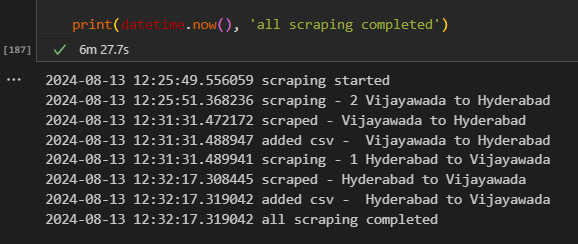